In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
current_dir = os.path.dirname(os.path.abspath("__file__"))
# Compute the parent directory (project root)
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
# Insert the project root into sys.path if it's not already there
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
           
import numpy as np
from registry import get_registry
from dual_datasets import VIGORDataset
from utils import get_data_transforms, process_data
from torchvision import transforms
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from qualitative_utils import get_images, get_heatmap_array, show_ground, get_heatmap, show_image, get_distance_array, show_image_rot
from tqdm import tqdm
from functools import partial

/home/qngo/semester-project-vita/CCVPE/.venv/lib/python3.10/site-packages/mmengine/optim/optimizer/zero_optimizer.py:11: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import \
/home/qngo/semester-project-vita/CCVPE/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/qngo/semester-project-vita/CCVPE/.venv/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/qngo/semester-project-vita/CCVPE/.venv/lib/python3.10/site-p

In [4]:
dataset_root='/work/vita/qngo/VIGOR'
area = 'samearea'
training = False # test dataset
pos_only = True
transform_grd, transform_sat = get_data_transforms()

vigor = VIGORDataset(dataset_root, 
                 split=area, 
                 train=training, 
                 pos_only=pos_only, 
                 transform=(transform_grd, transform_sat),
                 use_osm_tiles=True)

loaded data pikle
osm tiles loaded for NewYork
InputData::__init__: load /work/vita/qngo/VIGOR/splits_new/NewYork/satellite_list.txt 23279
loaded data pikle
osm tiles loaded for Seattle
InputData::__init__: load /work/vita/qngo/VIGOR/splits_new/Seattle/satellite_list.txt 44055
loaded data pikle
osm tiles loaded for SanFrancisco
InputData::__init__: load /work/vita/qngo/VIGOR/splits_new/SanFrancisco/satellite_list.txt 68310
loaded data pikle
osm tiles loaded for Chicago
InputData::__init__: load /work/vita/qngo/VIGOR/splits_new/Chicago/satellite_list.txt 90618
Sat loaded, data size:90618
InputData::__init__: load  /work/vita/qngo/VIGOR/splits_new/NewYork/same_area_balanced_test.txt 13884
InputData::__init__: load  /work/vita/qngo/VIGOR/splits_new/Seattle/same_area_balanced_test.txt 25759
InputData::__init__: load  /work/vita/qngo/VIGOR/splits_new/SanFrancisco/same_area_balanced_test.txt 39866
InputData::__init__: load  /work/vita/qngo/VIGOR/splits_new/Chicago/same_area_balanced_test.txt

In [5]:
def load_distances(experiment_name, base_path):
    return np.load(os.path.join(base_path, experiment_name, "distance_test.npy"))

base_path = '/work/vita/qngo/test_results'
experiment_name = 'soft_select_fusion_v2'
distances = load_distances(experiment_name, base_path)

In [6]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_wrapper = get_registry('soft_select_fusion_v2')('soft_select_fusion_v2', device)
experiment_name = 'soft_select_fusion_v2'

def load_model(model_wrapper, base_model_path: str, model_name: str, epoch: int):
    epoch = str(epoch)
    model_path = os.path.join(base_model_path, model_name, epoch, "model.pt")
    model_wrapper.load_model(model_path)

epoch='3'
base_model_path = "/work/vita/qngo/models/VIGOR/"
load_model(model_wrapper, base_model_path, experiment_name, epoch=epoch)
model_wrapper.set_model_to_eval()

distance_array = []

Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0


/home/qngo/semester-project-vita/CCVPE/wrappers/softSelectWrapper.py:324: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(path))


In [7]:
def deconstruct_weights(weights):
    weights_s = weights.squeeze(0)
    weights_volume = weights_s[0] # 16 - 1
    weights_15 = weights_s[1] # 16 - 1
    weights_10 = weights_s[2:6] # 32 - 2x2=4
    weights_4 = weights_s[6:22] # 64 - 4x4=16
    weights_2 = weights_s[22:86] # 128 - 8x8=64
    weights_0 = weights_s[86:342] # 256  - 16x16=256
    return weights_volume, weights_15, weights_10, weights_4, weights_2, weights_0

In [8]:
import seaborn as sns

def plot_weights(weights):
    weights_volume, weights_15, weights_10, weights_4, weights_2, weights_0 = deconstruct_weights(weights)
    fig, axs = plt.subplots(6,1, figsize=(20,20))
    w0 = weights_0[:,1].reshape((16,16))
    sns.heatmap(w0, vmin=0, vmax=1, ax=axs[0], square=True, cmap=sns.color_palette("cubehelix", as_cmap=True))
    axs[0].set_title(f"16x16  (1:sat, 0:osm)? mean : {np.mean(w0):.3f}")
    w2 = np.argmax(weights_2, axis=1).reshape((8, 8))
    sns.heatmap(w2, vmin=0, vmax=1,ax=axs[1], square=True)
    axs[1].set_title(f'8x8 mean: {np.mean(w2):.3f}')
    w4 = weights_4[:,1].reshape((4,4))
    sns.heatmap(w4, vmin=0, vmax=1,ax=axs[2], square=True)
    axs[2].set_title(f'4x4 mean: {np.mean(w4):.3f}')
    w10 = weights_10[:,1].reshape((2,2))
    sns.heatmap(w10, vmin=0, vmax=1,ax=axs[3], square=True)
    axs[3].set_title(f'2x2 mean: {np.mean(w10):.3f}')
    w15 = weights_15[1].reshape((1,1))
    sns.heatmap(w15, vmin=0, vmax=1,ax=axs[4], square=True)
    axs[4].set_title(f'1x1 mean: {np.mean(w15):.3f}')
    wvol = weights_volume[1].reshape((1,1))
    sns.heatmap(wvol, vmin=0, vmax=1,ax=axs[5], square=True)
    axs[5].set_title(f'1x1 volume mean: {np.mean(wvol):.3f}')

In [9]:
from torchvision.transforms.v2 import GaussianNoise
from qualitative_utils import show_image_subplot

def gaussian_noise(x, scale=0.0):
    return GaussianNoise(sigma=scale, clip=False)(x)

In [10]:
import torchvision.transforms.functional as TF
import random
import math

def random_rotate(elements: list[torch.Tensor], gt_orientation=None, angle=None) -> list[torch.Tensor]:
    if angle is None:
        angle = random.choice([0, 90, 180])

    print('rotated by ', angle)
    res = []
    for elem in elements:
        print('elem', elem.shape)
        elem_rot = TF.rotate(elem, angle)
        res.append(elem_rot)

    if gt_orientation is not None:
        print('gt_orientation shape', gt_orientation.shape)
        gt_orientation = TF.rotate(gt_orientation, angle)
        # 3) adjust your GT orientation vector (in degrees)
        #    e.g. if gt_orientation is a heading angle:
        θ = math.radians(angle)
        cosθ = math.cos(θ)
        sinθ = math.sin(θ)
        
    
        ux = gt_orientation[:,0]   # shape (H, W)
        uy = gt_orientation[:,1]
        # apply the 2×2 rotation matrix
        ux2 =  cosθ * ux - sinθ * uy
        uy2 =  sinθ * ux + cosθ * uy
        ori_map2 = torch.stack([ux2, uy2], dim=0)  # (2, H, W)
        ori_map2 = ori_map2.permute(1, 0 ,2, 3)
    else:
        ori_map2 = None
    
    # gt_rot = (gt_orientation + angle) % 360
    # print('gt orientation shape ', gt_orientation.shape)
    # print('gt orientation ', gt_orientation)
    # print('gt_rot ',gt_rot)
    return res, ori_map2, angle

# elements = [sat, osm, gt, gt_with_ori]
# elements_rot, gt_ori_rot = random_rotate(elements, gt_orientation)


rotated by  90
elem torch.Size([1, 3, 512, 512])
elem torch.Size([1, 3, 512, 512])
elem torch.Size([1, 1, 512, 512])
elem torch.Size([1, 20, 512, 512])
gt_orientation shape torch.Size([1, 2, 512, 512])
torch.Size([1, 3, 320, 640])
rotated by  90
elem torch.Size([3, 512, 512])
elem torch.Size([3, 512, 512])
elem torch.Size([1, 512, 512])
show image gt ori shape torch.Size([1, 2, 512, 512])


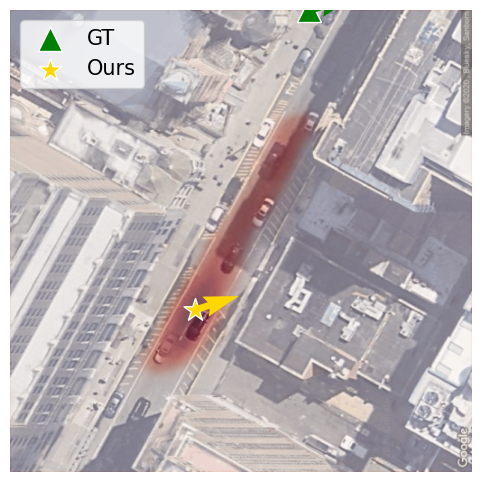

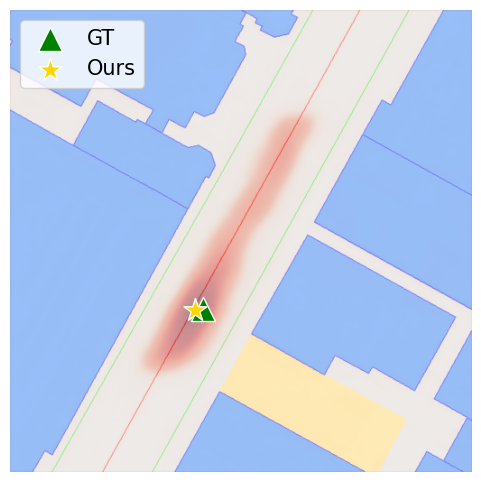

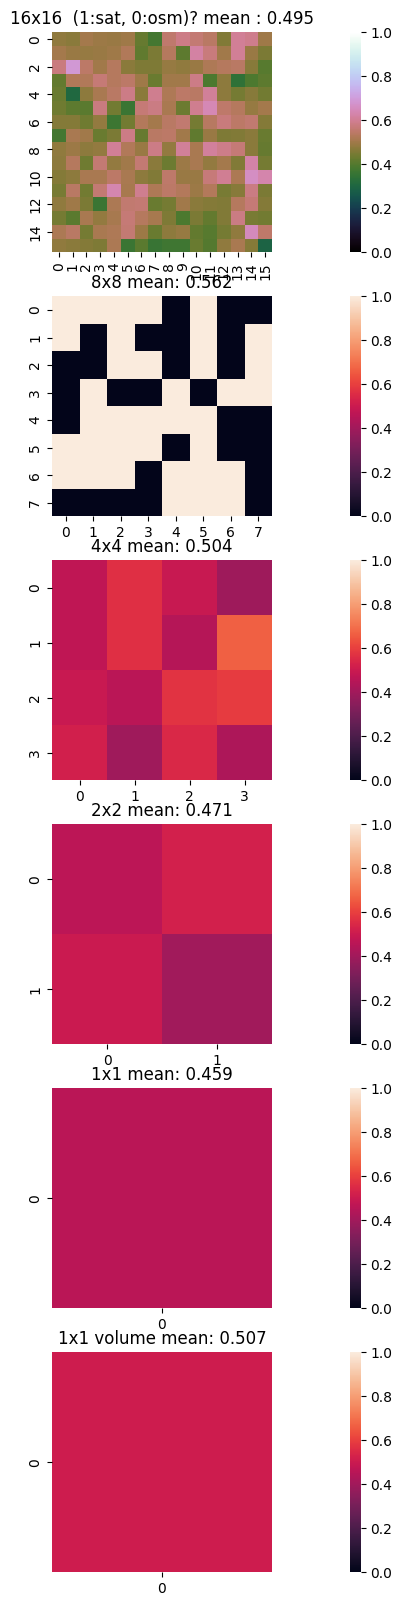

In [11]:
idx = 1
data = vigor.__getitem__(idx)
grd, sat, osm, gt, gt_with_ori, gt_orientation, city, gt_flattened = data
grd = grd.to(device).unsqueeze(0)
sat = sat.to(device).unsqueeze(0)
osm = osm.to(device).unsqueeze(0)
gt = gt.to(device).unsqueeze(0)
gt_with_ori = gt_with_ori.to(device).unsqueeze(0)
gt_orientation = gt_orientation.to(device).unsqueeze(0)
elements = [sat, osm, gt, gt_with_ori]
elements_rot, gt_ori_rot, angle = random_rotate(elements, gt_orientation)
sat = elements_rot[0]
osm = elements_rot[1]
gt = elements_rot[2]
gt_with_ori = elements_rot[3]
gt_orientation = gt_ori_rot

print(grd.shape)
def infer(osm, sat, grd, gt, gt_with_ori, gt_orientation, city, gt_flattened):
    data = grd, sat, osm, gt, gt_with_ori, gt_orientation, city, gt_flattened
    for d in data:
        try:
            d = d.unsqueeze(0).to(device)
        except:
            pass
    output, loss, heatmap = model_wrapper.infer(data)
    return heatmap, output

infer_p = partial(infer, grd=grd, gt=gt, gt_with_ori=gt_with_ori, gt_orientation=gt_orientation, city=city, gt_flattened=gt_flattened)

scale = 0.0
osm_n = gaussian_noise(osm, scale=scale)
heatmap, output = infer_p(osm_n, sat)
grd_p, sat_p, osm_p, gt_p = get_images(idx, vigor)

elements = [sat_p, osm_p, gt_p]
elements_rot, _, _ = random_rotate(elements, angle=angle)
sat_p = elements_rot[0]
osm_p = elements_rot[1]
gt_p = elements_rot[2]

osm_p = gaussian_noise(osm_p, scale=scale)
show_image_rot(sat_p, grd_p, heatmap.squeeze(0).squeeze(0).cpu().detach().numpy(), gt_p, gt_orientation, gt_orientation)
show_image(osm_p, grd_p, heatmap.squeeze(0).squeeze(0).cpu().detach().numpy(), gt_p)

weights = output[0]
# print('weights ', weights)
plot_weights(weights.cpu().detach().numpy())

In [12]:
idx = 1
data = vigor.__getitem__(idx)
grd, sat, osm, gt, gt_with_ori, gt_orientation, city, gt_flattened = data
grd = grd.to(device).unsqueeze(0)
sat = sat.to(device).unsqueeze(0)
osm = osm.to(device).unsqueeze(0)
gt = gt.to(device).unsqueeze(0)
gt_with_ori = gt_with_ori.to(device).unsqueeze(0)
gt_orientation = gt_orientation.to(device).unsqueeze(0)

In [13]:
gt_orientation

tensor([[[[-0.7987, -0.7987, -0.7987,  ..., -0.7987, -0.7987, -0.7987],
          [-0.7987, -0.7987, -0.7987,  ..., -0.7987, -0.7987, -0.7987],
          [-0.7987, -0.7987, -0.7987,  ..., -0.7987, -0.7987, -0.7987],
          ...,
          [-0.7987, -0.7987, -0.7987,  ..., -0.7987, -0.7987, -0.7987],
          [-0.7987, -0.7987, -0.7987,  ..., -0.7987, -0.7987, -0.7987],
          [-0.7987, -0.7987, -0.7987,  ..., -0.7987, -0.7987, -0.7987]],

         [[-0.6017, -0.6017, -0.6017,  ..., -0.6017, -0.6017, -0.6017],
          [-0.6017, -0.6017, -0.6017,  ..., -0.6017, -0.6017, -0.6017],
          [-0.6017, -0.6017, -0.6017,  ..., -0.6017, -0.6017, -0.6017],
          ...,
          [-0.6017, -0.6017, -0.6017,  ..., -0.6017, -0.6017, -0.6017],
          [-0.6017, -0.6017, -0.6017,  ..., -0.6017, -0.6017, -0.6017],
          [-0.6017, -0.6017, -0.6017,  ..., -0.6017, -0.6017, -0.6017]]]],
       device='cuda:0')

In [17]:
angle = 180
# gt_orientation = TF.rotate(gt_orientation, angle)
# 3) adjust your GT orientation vector (in degrees)
#    e.g. if gt_orientation is a heading angle:
θ = math.radians(angle)
cosθ = math.cos(θ)
sinθ = math.sin(θ)

ux = gt_orientation[:,0]   # shape (H, W)
uy = gt_orientation[:,1]
# apply the 2×2 rotation matrix
ux2 =  cosθ * ux - sinθ * uy
uy2 =  sinθ * ux + cosθ * uy
ori_map2 = torch.stack([ux2, uy2], dim=0)  # (2, H, W)
ori_map2 = ori_map2.permute(1, 0 ,2, 3)

In [18]:
ori_map2

tensor([[[[0.7987, 0.7987, 0.7987,  ..., 0.7987, 0.7987, 0.7987],
          [0.7987, 0.7987, 0.7987,  ..., 0.7987, 0.7987, 0.7987],
          [0.7987, 0.7987, 0.7987,  ..., 0.7987, 0.7987, 0.7987],
          ...,
          [0.7987, 0.7987, 0.7987,  ..., 0.7987, 0.7987, 0.7987],
          [0.7987, 0.7987, 0.7987,  ..., 0.7987, 0.7987, 0.7987],
          [0.7987, 0.7987, 0.7987,  ..., 0.7987, 0.7987, 0.7987]],

         [[0.6017, 0.6017, 0.6017,  ..., 0.6017, 0.6017, 0.6017],
          [0.6017, 0.6017, 0.6017,  ..., 0.6017, 0.6017, 0.6017],
          [0.6017, 0.6017, 0.6017,  ..., 0.6017, 0.6017, 0.6017],
          ...,
          [0.6017, 0.6017, 0.6017,  ..., 0.6017, 0.6017, 0.6017],
          [0.6017, 0.6017, 0.6017,  ..., 0.6017, 0.6017, 0.6017],
          [0.6017, 0.6017, 0.6017,  ..., 0.6017, 0.6017, 0.6017]]]],
       device='cuda:0')